# **Implémentation du modèle**
---

## Introduction

Contrairement au notebook "modèle", ici nous nous intéressons aux chocs de la politique monétaire américaine sur les pays européens.



Ce notebook contient les codes nécessaire à la mise en place du modèle. Le modèle est inspiré de celui de Iacoviello et Navarro : 

- La première étape consiste à identifier les chocs de politique monétaire, en prenant le résidu de la régression du taux d'intérêt sur l'écart d'inflation par rapport à la cible et l'output gap ou le chômage. En réalité Iacoviello et Navarro utilisent des lags et valeurs présentes de l'inflation, des spreads de crédit, du PIB et des lags des taux des fonds fédéraux.
Il nous manque donc l'output gap, l'inflation et le chômage de la zone euro
- La deuxième étape consiste à estimer l'impact de ces chocs sur l'activité économique (PIB, emploi ...) en régressant ces variables sur les chocs et des variables de contrôles (4 lags du PIB et des trends linéaires et quadratiques)

## Formatage des données

In [4]:
# import des données américaines

!pip install openpyxl 
import pandas as pd

sheets_to_load = ["Daily, Close", "Monthly", "Quarterly"]  # Noms des feuilles à importer
dfs = pd.read_excel("../Données_extraites/data_US.xlsx", sheet_name=sheets_to_load, header=0)
# Accéder aux DataFrames importés
dfD = dfs["Daily, Close"]
dfM = dfs["Monthly"]
dfQ = dfs["Quarterly"]

# renommer les variables
dfD.columns = dfD.iloc[0] 
dfD = dfD[1:].reset_index(drop=True)

dfM.columns = dfM.iloc[0] 
dfM = dfM[1:].reset_index(drop=True)


# Il faut trimestrialiser les données (on prend la moyenne)

dfM["date"] = pd.to_datetime(dfM["date"])  # Convertir en datetime
dfM = dfM.set_index("date")  # Définir la colonne "date" comme index
dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre

dfD["date"] = pd.to_datetime(dfD["date"])  # Convertir en datetime
dfD = dfD.set_index("date")  # Définir la colonne "date" comme index
dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre

# harmoniser les dates
dfD_Q.index = dfD_Q.index.to_period("Q")  
dfM_Q.index = dfM_Q.index.to_period("Q")

dfQ=dfQ.rename(columns={"observation_date":"date"})
dfQ = dfQ.set_index("date")
dfQ.index = dfQ.index.to_period("Q")



/tmp/ipykernel_8545/4245104104.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre
/tmp/ipykernel_8545/4245104104.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre


In [5]:
import numpy as np
data_US = dfM_Q.merge(dfD_Q, on='date').merge(dfQ, on='date')

# Créer la variable d'inflation (sur 4 trimestres)
data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage

# Créer une variable de temps et tendnce quadratique
data_US['time'] = range(1, len(data_US) + 1)
data_US['time_squared'] = data_US['time'] ** 2

# Créer 4 lags pour chaque variable
for col in data_US.columns:
    for lag in range(1, 5):  # Créer les lags 1, 2, 3, 4
        data_US[f"{col}_lag{lag}"] = data_US[col].shift(lag)


# Filtrer les colonnes contenant 'GDP'
gdp_columns = [col for col in data_US.columns if 'GDP' in col]

# Créer de nouvelles colonnes en log pour chaque colonne contenant 'GDP'
for col in gdp_columns:
    data_US[f"{col}_log"] = np.log(data_US[col])



/tmp/ipykernel_8545/3975620391.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage


In [6]:
data_US

,CPI,Policy rate,Industrial production,activité mensualisée,spread corporate,GDPC1,inflation,time,time_squared,CPI_lag1,...,time_lag4,time_squared_lag1,time_squared_lag2,time_squared_lag3,time_squared_lag4,GDPC1_log,GDPC1_lag1_log,GDPC1_lag2_log,GDPC1_lag3_log,GDPC1_lag4_log
date,,,,,,,,,,,,,,,,,,,,,
1996Q4,158.666667,5.28,76.830067,99.577753,0.6,12037.775,NaN,1,1,None,...,NaN,NaN,NaN,NaN,NaN,9.395805,NaN,NaN,NaN,NaN
1997Q1,159.633333,5.276667,78.286233,99.592907,0.591475,12115.472,NaN,2,4,158.666667,...,NaN,1.0,NaN,NaN,NaN,9.402239,9.395805,NaN,NaN,NaN
1997Q2,160.0,5.523333,79.403833,99.823247,0.584615,12317.221,NaN,3,9,159.633333,...,NaN,4.0,1.0,NaN,NaN,9.418754,9.402239,9.395805,NaN,NaN
1997Q3,160.8,5.533333,81.2606,100.017223,0.568308,12471.010,NaN,4,16,160.0,...,NaN,9.0,4.0,1.0,NaN,9.431162,9.418754,9.402239,9.395805,NaN
1997Q4,161.666667,5.506667,83.325533,100.0244,0.667273,12577.495,1.890756,5,25,160.8,...,1.0,16.0,9.0,4.0,1.0,9.439664,9.431162,9.418754,9.402239,9.395805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q4,308.158333,5.33,102.6986,100.44725,1.194923,22960.600,3.236199,109,11881,306.042333,...,105.0,11664.0,11449.0,11236.0,11025.0,10.041535,10.033679,10.023021,10.016970,10.010073
2024Q1,310.974333,5.33,102.242767,NaN,0.987969,23053.545,3.247987,110,12100,308.158333,...,106.0,11881.0,11664.0,11449.0,11236.0,10.045575,10.041535,10.033679,10.023021,10.016970
2024Q2,313.095667,5.33,102.8633,NaN,0.914394,23223.906,3.187395,111,12321,310.974333,...,107.0,12100.0,11881.0,11664.0,11449.0,10.052937,10.045575,10.041535,10.033679,10.023021


## Détermination des chocs

In [7]:
data_US.columns

Index(['CPI', 'Policy rate', 'Industrial production', 'activité mensualisée',
       'spread corporate', 'GDPC1', 'inflation', 'time', 'time_squared',
       'CPI_lag1', 'CPI_lag2', 'CPI_lag3', 'CPI_lag4', 'Policy rate_lag1',
       'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
       'Industrial production_lag1', 'Industrial production_lag2',
       'Industrial production_lag3', 'Industrial production_lag4',
       'activité mensualisée_lag1', 'activité mensualisée_lag2',
       'activité mensualisée_lag3', 'activité mensualisée_lag4',
       'spread corporate_lag1', 'spread corporate_lag2',
       'spread corporate_lag3', 'spread corporate_lag4', 'GDPC1_lag1',
       'GDPC1_lag2', 'GDPC1_lag3', 'GDPC1_lag4', 'inflation_lag1',
       'inflation_lag2', 'inflation_lag3', 'inflation_lag4', 'time_lag1',
       'time_lag2', 'time_lag3', 'time_lag4', 'time_squared_lag1',
       'time_squared_lag2', 'time_squared_lag3', 'time_squared_lag4',
       'GDPC1_log', 'GDPC1_lag1_log',

### 1er essai : modèle avec 4 lags

In [8]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean=data_US_clean.apply(pd.to_numeric, errors='coerce')
# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes sauf 'key_rate' et 'TIME_PERIOD'
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
'inflation','inflation_lag1','inflation_lag2', 'inflation_lag3', 'inflation_lag4',
'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log','GDPC1_lag4_log',
'spread corporate','spread corporate_lag1', 'spread corporate_lag2','spread corporate_lag3', 'spread corporate_lag4',
'time_squared']]



# Ajouter une constante pour l'intercept dans la régression
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Afficher le résumé de la régression
print(model.summary())


with open("regression_results4 US.tex", "w") as f:
    f.write(model.summary().as_latex())

    
# Sauvegarder les résultats dans un fichier CSV
data_US_clean[['time', 'monetary_shocks']].to_csv('identified_monetary_shocks.csv', index=False)

# Exporter les résultats de la régression en latex
with open("regression_results_US.tex", "w") as f:
    f.write(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     280.2
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.58e-65
Time:                        09:14:22   Log-Likelihood:                 1.2524
No. Observations:                 101   AIC:                             39.50
Df Residuals:                      80   BIC:                             94.41
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.18

In [9]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1', 'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
                   'inflation', 'inflation_lag1', 'inflation_lag2', 'inflation_lag3', 'inflation_lag4',
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log', 'GDPC1_lag4_log',
                   'spread corporate', 'spread corporate_lag1', 'spread corporate_lag2', 
                   'spread corporate_lag3', 'spread corporate_lag4', 'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Fonction pour ajouter les étoiles de significativité
def significance_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.1:
        return '*'
    else:
        return ''

# Appliquer la fonction avant de formater les nombres
p_values = model.pvalues.apply(significance_stars)

# Créer un DataFrame des résultats
results_df = pd.DataFrame({
    'Coefficient': model.params.map('{:.4f}'.format) + p_values,
    'Std. Error': model.bse.map('{:.4f}'.format),
    't-Statistic': model.tvalues.map('{:.4f}'.format),
    'P-Value': model.pvalues.map('{:.4f}'.format),
})

# Reformater les résultats pour summary_col
model_summary = summary_col([model], stars=True, float_format="%.4f",
                            model_names=["Régression"],
                            info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}",
                                       'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}",
                                       'F-statistic': lambda x: f"{x.fvalue:.2f} (p={x.f_pvalue:.4g})"})

# Exporter le tableau en LaTeX
latex_table = model_summary.as_latex()

with open("regression_results_full_US.tex", "w") as f:
    f.write(latex_table)

# Affichage du tableau final
print(model_summary)


                           Régression    
-----------------------------------------
const                 0.1814             
                      (8.7748)           
Policy rate_lag1      1.6687***          
                      (0.1167)           
Policy rate_lag2      -0.7024***         
                      (0.2355)           
Policy rate_lag3      -0.1986            
                      (0.2396)           
Policy rate_lag4      0.1693             
                      (0.1263)           
inflation             0.0569             
                      (0.0436)           
inflation_lag1        -0.0207            
                      (0.0643)           
inflation_lag2        0.0168             
                      (0.0640)           
inflation_lag3        0.0110             
                      (0.0639)           
inflation_lag4        0.0210             
                      (0.0453)           
GDPC1_log             5.9692**           
                      (2.7764)   

### 2ème essai: modèle avec 2 lags

In [10]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Ajouter les étoiles de significativité
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les résultats formatés
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les étoiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# Réorganiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au début
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le résumé de la régression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     480.0
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.14e-74
Time:                        09:14:23   Log-Likelihood:                -2.1134
No. Observations:                 101   AIC:                             30.23
Df Residuals:                      88   BIC:                             64.22
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.61

#### Lissage exponentiel de la série pour mieux identifier les chocs

#### Lissage en moyenne glissante

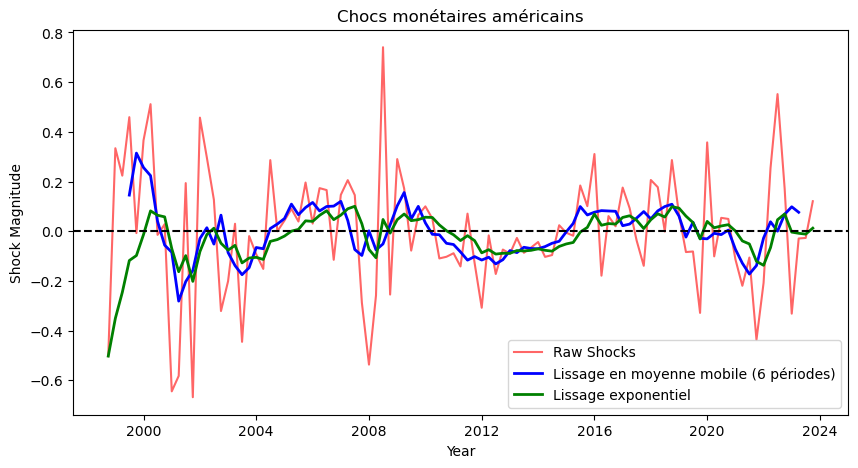

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 périodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks'].rolling(window=6, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks'].ewm(span=10, adjust=False).mean()

# Tracer les séries
plt.figure(figsize=(10,5))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks'], color='red', alpha=0.6, label='Raw Shocks')  # Série brute
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Lissage en moyenne mobile (6 périodes)')  # Série lissée
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")  # Ligne de base
plt.xlabel('Year')
plt.ylabel('Shock Magnitude')
plt.title('Chocs monétaires américains')
plt.legend()
plt.savefig("monetary_shocks.png", dpi=300)  
plt.show()

## 2ème partie du modèle: impact des chocs sur les pays européens

Nous allons maintenant estimer avec une régression de panel l'impact des chocs de politique monétaire identifiés, sur différentes variables (GDP, employment ? ...). La méthode utilisé est celle de Jorda (2005), la méthode de projection locale. Cela consiste à "estimer des projections locales à chaque période au lieu d'extrapoler sur des horizons lointains à partir d'un modèle."
Nous allons estimer une équation de la forme suivante, comme dans Iacoviello & Navarro (2018) :

$$
y_{i,t+h} = \alpha_{i,h} + \beta_h u_t + A_{h,i} Z_{i,t} + \varepsilon_{i,t+h}
$$

où :

- $y_{i,t+h}$ est le PIB du pays $ i $ au temps $t$,
- $\alpha_{i,h} $ est un effet fixe spécifique au pays,
- $u_t$ est le choc monétaire,
- $Z_{i,t}$  représente les variables de contrôle : 4 lags du PIB, des tendances linéaire et quadratique,
- $\varepsilon_{i,t+h}$  est le terme d'erreur.

Pour chaque h il faut estimer un $\beta_h$, ensuite il faut faire les IRF (fonctions de réponse impulsionnelle) pour les différents Y qu'on utilise.


Pour les variables de contrôle, il faut sûrement tester lesquelles sont les meilleures, ne pas forcément reproduire exactement le modèle.

On a des données trimestrielles donc on prend h de 0 à 4 ou 8

In [21]:
# import des données
import pandas as pd
data=pd.read_excel("../base_de_données_v1.xlsx")

In [ ]:
# merger les données des pays avec les chocs
# Il faudrait mettre les données en format long pour faire le modèle (1 colonne pays, 1 colonne time et 1 colonne par variable)

In [ ]:

# Renommer la colonne temps
data = data.rename(columns={"Unnamed: 0": "Time"})

# Conversion en format long
df_long = data.melt(id_vars=["Time"], var_name="Variable_Country", value_name="Value")
# Séparer le pays et la variable
df_long[['Variable', 'Country']] = df_long['Variable_Country'].str.rsplit('_', n=1, expand=True)

# Réorganiser les colonnes et supprimer la colonne d'origine
df_long = df_long[["Time", "Country", "Variable", "Value"]]

# Afficher les premières lignes du format long
df_long

data = df_long
